In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in LES data

les_file = 'data_les/shi3_isdac_sfc6_pTqv_fthqv_lw_3_abifm_final/dharma.soundings.cdf'
les = xr.open_dataset(les_file)
les = les.sel(time=3600*3,method='nearest')         # harvest output after LES is roughly steady state (3h)
izt_cloud_top = np.max(np.where(les.ql.data>1.e-6)) # identify cloud top z-index (where LWC becomes negligible)
les = les[dict(zt=np.arange(izt_cloud_top+1))]      # 1D model domain extends only to cloud top
les = les[['T','ql','RH']]                          # retain only variables needed
les.RH.data = les.RH.data / 100.                    # convert RH % to fraction

# calculate ∆aw for ABIFM

les = les.assign( delta_aw = les['RH'] -
    ( np.exp(9.550426-5723.265/les['T']+3.53068*np.log(les['T'])-0.00728332*les['T']) /
    ( np.exp(54.842763-6763.22/les['T']-4.210*np.log(les['T'])+
    0.000367*les['T']+np.tanh(0.0415*(les['T']-218.8))*
    (53.878-1331.22/les['T']-9.44523*np.log(les['T'])+0.014025*les['T'])) ) ) )

In [6]:
# set up model grids and arrays
# prognostic variables: 
#     mod_inp(t,z) = INP number concentration [L-1]
#     mod_ni(t,z)  = ice crystal number concentration [L-1]
# reported process rates: 
#     mod_nuc(t,z) = INP nucleation rate = ice formation rate [L-1 s-1]

final_t = 3.*3600  # simulation time [s]
delta_t = 10.     # time step [s]

mod_nt  = int(final_t/delta_t)+1       # number of time steps
times   = np.arange(mod_nt)*delta_t       # time array [s]
mod_nz  = les.RH.data.size                # number of vertical grid cells
heights = les.zt.data                     # height array [m]
delta_z = heights[mod_nz-1]-heights[mod_nz-2] # ∆z used in calculations, same for all levels [m]

mod_arr = xr.DataArray(np.zeros(shape=(mod_nt,mod_nz)),
                       coords=[('time', times),('height', heights)])
mod_arr.time.attrs['long_name']= 'Time'
mod_arr.time.attrs['units']= 's'
mod_arr.height.attrs['long_name']= 'Height'
mod_arr.height.attrs['units']= 'm'

mod_inp = mod_arr.copy()
mod_inp.attrs['name'] = 'INP'
mod_inp.attrs['units'] = 'L-1'

mod_ice = mod_arr.copy()
mod_ice.attrs['name'] = 'Ice'
mod_ice.attrs['units'] = 'L-1'

mod_nuc = mod_arr.copy()
mod_nuc.attrs['name'] = 'Nucleation Rate'
mod_nuc.attrs['units'] = 'L-1 s-1'

In [7]:
# specify initial conditions and run parameters

# domain-uniform initial monomodal INP that are also hygroscopic

inp_init = 2.e0                       # particle number concentration [L-1]
inp_diam = 1.e-4                      # particle diameter [cm]
inp_surf = 4*np.pi*(inp_diam/2.)**2   # surface area per particle [cm2]

# specified ABIFM parameters
# illite
IN_c =  1.60671
IN_m = 14.96639
Jhet = np.double(10.**(IN_c + IN_m*les.delta_aw.data))    # nucleation rate [cm-2 s-1]

# specified quantities derived from LES offline (see Fridlind et al. 2012, doi:10.1175/JAS-D-11-052.1)

w_e_ent = 0.1e-3   # cloud-top entrainment rate [m/s]
tau_mix = 3600.    # boundary-layer mixing time scale [s]
v_f_ice = 0.3      # number-weighted ice crystal fall speed at the surface [m/s]

In [8]:
# run the model

# initialize INP

mod_inp[dict(time=0)] = inp_init    # domain uniform monomodal INP (in- and above-cloud)

# loop over time steps

for it in range(1,mod_nt):
    # get values at last time step as 1D numpy arrays
    n_inp_init = np.squeeze(mod_inp.isel(time=[it-1]).values.copy())
    n_ice_init = np.squeeze(mod_ice.isel(time=[it-1]).values.copy())
    # nucleation of ice
    inp_activated = n_inp_init*Jhet*inp_surf*delta_t
    # cloud top entrainment of INP
    inp_entrained = np.zeros(mod_nz)
    inp_entrained[mod_nz-1] = w_e_ent/delta_z*delta_t*(inp_init-n_inp_init[mod_nz-1])
    # sedimentation of ice
    ice_sedimented_out = n_ice_init*v_f_ice/delta_z*delta_t
    ice_sedimented_in = np.zeros(mod_nz)
    ice_sedimented_in[0:mod_nz-2] = ice_sedimented_out[1:mod_nz-1]
    # new ice and INP profiles
    n_ice_new = n_ice_init.copy() + inp_activated - ice_sedimented_out + ice_sedimented_in
    n_inp_new = n_inp_init.copy() - inp_activated + inp_entrained
    # apply turbulent mixing
    n_ice_new = (n_ice_new + np.mean(n_ice_new)*delta_t/tau_mix)/(1+delta_t/tau_mix)
    n_inp_new = (n_inp_new + np.mean(n_inp_new)*delta_t/tau_mix)/(1+delta_t/tau_mix)
    # save new values and nucleation rate
    mod_ice[dict(time=it)] = n_ice_new.copy()
    mod_inp[dict(time=it)] = n_inp_new.copy()
    mod_nuc[dict(time=it)] = inp_activated.copy()

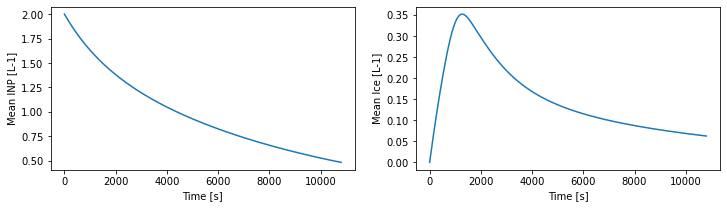

In [9]:
# plot time series of domain-mean quantities

fig = plt.figure(figsize=[12,3])

ax1 = fig.add_subplot(121)
mod_inp.mean(dim='height').plot()
ax1.set_ylabel('Mean INP [L-1]')

ax2 = fig.add_subplot(122)
mod_ice.mean(dim='height').plot()
ax2.set_ylabel('Mean Ice [L-1]')

plt.show()

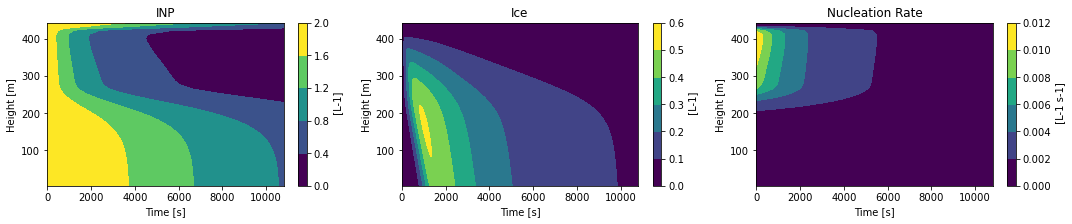

In [10]:
# plot time series of domain-mean quantities

fig = plt.figure(figsize=[18,3])

ax1 = fig.add_subplot(131)
mod_inp.plot.contourf('time')
ax1.set_title('INP')

ax2 = fig.add_subplot(132)
mod_ice.plot.contourf('time')
ax2.set_title('Ice')

ax3 = fig.add_subplot(133)
mod_nuc.plot.contourf('time')
ax3.set_title('Nucleation Rate')

plt.show()